# INTEGRATE Synthetic Case Study example
An example using inverting data obtained from synthetic reference model


In [1]:
try:
    # Check if the code is running in an IPython kernel (which includes Jupyter notebooks)
    get_ipython()
    # If the above line doesn't raise an error, it means we are in a Jupyter environment
    # Execute the magic commands using IPython's run_line_magic function
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
except:
    # If get_ipython() raises an error, we are not in a Jupyter environment
    # # # # # # # # # #%load_ext autoreload
    # # # # # # # # # #%autoreload 2
    pass

import integrate as ig
# check if parallel computations can be performed
parallel = ig.use_parallel(showInfo=1)

import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
hardcopy=True

Notebook detected. Parallel processing is OK


# Create The reference model and data

In [2]:
# Create reference model

# select the type of referenc model
case = 'wedge'
case = '3layer'

z_max = 60
rho = [120,10,120]
#rho = [10,120,10]
rho = [120,10,10]
#rho = [720,10,520]
dx=0.1
if case.lower() == 'wedge':
    # Make Wedge MODEL
    M_ref, x_ref, z_ref = ig.synthetic_case(case='Wedge', wedge_angle=10, dx=dx, z_max=z_max, dz=.5, x_max=100, z1=15, rho = rho)
elif case.lower() == '3layer':
    # Make 3 layer MODEL
    M_ref, x_ref, z_ref = ig.synthetic_case(case='3layer', dx=dx, rho1_1 = rho[0], rho1_2 = rho[1], rho3=rho[2], x_max = 100, x_range = 10)

# Create reference data
f_data_h5 = '%s_%d.h5' % (case,z_max)    
thickness = np.diff(z_ref)
# Get an exampele of a GEX file
file_gex = ig.get_case_data(case='DAUGAARD', filelist=['TX07_20231016_2x4_RC20-33.gex'])[0]
D_ref = ig.forward_gaaem(C=1./M_ref, thickness=thickness, file_gex=file_gex)

# Initialize random number generator to sample from noise model!
rng = np.random.default_rng()
d_std = 0.05
d_std_base = 1e-12
D_std = d_std * D_ref + d_std_base
D_noise = rng.normal(0, D_std, D_ref.shape)
D_obs = D_ref + D_noise

# Write to hdf5 file
# Add option to reomve existing file before writing!
f_data_h5 = ig.write_data_gaussian(D_obs, D_std = D_std, f_data_h5 = f_data_h5, id=1, showInfo=1)
#check_data(f_data_h5)

Getting data for case: DAUGAARD
--> Got data for case: DAUGAARD


ModuleNotFoundError: No module named 'gatdaem1d'

NameError: name 'D_ref' is not defined

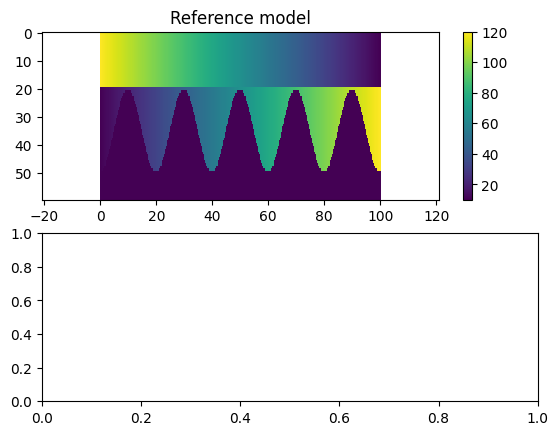

In [3]:
# Plot the model and data
plt.figure()
plt.subplot(2,1,1)
xx_ref, zz_ref = np.meshgrid(x_ref, z_ref)
plt.pcolor(xx_ref,zz_ref,M_ref.T)
plt.gca().invert_yaxis()
plt.axis('equal')
plt.colorbar()
plt.title('Reference model')
plt.subplot(2,1,2)
plt.semilogy(x_ref,D_ref);
plt.title('Reference data')

ig.plot_data(f_data_h5)

## Create prior model and data

prior_layered:   0%|                                                                                                                                                      | 0/500000 [00:00<?, ?it/s]

prior_layered:  25%|█████████████████████████████████                                                                                                    | 124251/500000 [00:01<00:03, 124250.47it/s]

prior_layered:  50%|██████████████████████████████████████████████████████████████████▏                                                                  | 248987/500000 [00:02<00:02, 124535.62it/s]

prior_layered:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 373523/500000 [00:03<00:01, 124153.11it/s]

prior_layered: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 498171/500000 [00:04<00:00, 124347.95it/s]

File PRIOR_UNIFORM_NL_2-3_log-uniform_N500000.h5 does not exist.


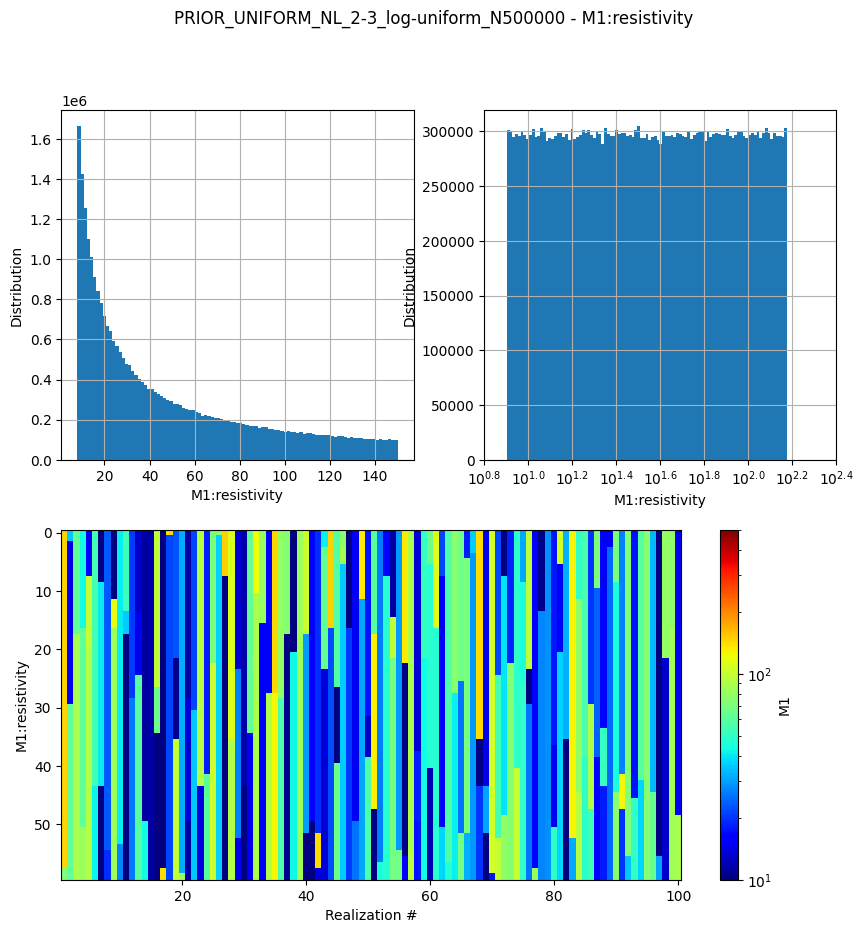

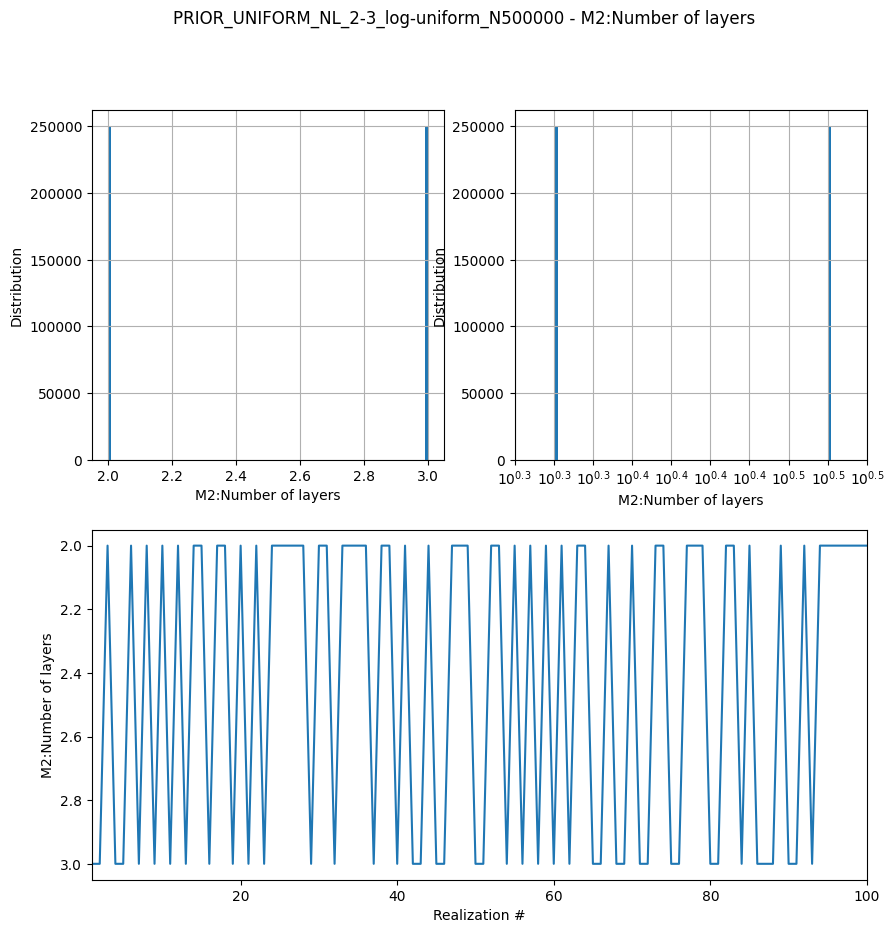

In [4]:
N=500000 # sample size 
RHO_dist='log-uniform'
#RHO_dist='uniform'
RHO_min=0.8*min(rho)
RHO_max=1.25*max(rho)
NLAY_min=2
NLAY_max=3
f_prior_h5 = ig.prior_model_layered(N=N,
                                    lay_dist='uniform', z_max = z_max, 
                                    NLAY_min=NLAY_min, NLAY_max=NLAY_max, 
                                    RHO_dist=RHO_dist, RHO_min=RHO_min, RHO_max=RHO_max)

ig.plot_prior_stats(f_prior_h5)

In [5]:
f_prior_data_h5 = ig.prior_data_gaaem(f_prior_h5, file_gex)

# plot prior and observed data to chech that the prior data span the same range as the observed data
ig.plot_data_prior(f_prior_data_h5,f_data_h5,nr=1000,alpha=1, ylim=[1e-13,1e-5], hardcopy=hardcopy) 

Creating a copy of PRIOR_UNIFORM_NL_2-3_log-uniform_N500000.h5
                as PRIOR_UNIFORM_NL_2-3_log-uniform_N500000_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5


prior_data_gaaem: Using 32 parallel threads.


ModuleNotFoundError: No module named 'gatdaem1d'

## Perform inversion

In [6]:
f_post_h5 = ig.integrate_rejection(f_prior_data_h5, f_data_h5, 
                                    parallel=parallel, 
                                    Ncpu=8,
                                    use_N_best=0
                                    )

NameError: name 'f_prior_data_h5' is not defined

In [7]:
clim = [0.8*min(rho), 1.2*max(rho)]
ig.plot_profile(f_post_h5, i1=0, i2=1000, hardcopy=hardcopy,  clim = clim)
ig.plot_profile(f_post_h5, i1=0, i2=1000, hardcopy=hardcopy,  im=2)

NameError: name 'f_post_h5' is not defined

In [8]:
ig.plot_data_prior_post(f_post_h5, i_plot=0, hardcopy=hardcopy)

NameError: name 'f_post_h5' is not defined

## Compare reference model to posterior median

In [9]:
# Read 'M1/Median' from f_post_h5
with h5py.File(f_post_h5, 'r') as f_post:
    M_median = f_post['/M1/Median'][:]
    M_mean = f_post['/M1/Mean'][:]
    M_std = f_post['/M1/Std'][:]

with h5py.File(f_prior_h5,'r') as f_prior:
    # REad 'x' feature from f_prior
    z =  f_prior['/M1'].attrs['x']

xx, zz = np.meshgrid(x_ref, z)

# Make a figure with two subplots, each with plt.pcolor(xx,zz,M_median.T) and, plt.pcolor(xx_ref,zz_ref,M_ref.T), and use the same colorbar and x.axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

clim = [0.8*min(rho), 1.2*max(rho)]
# Fisrt subplot - ref model
c1 = ax1.pcolor(xx_ref, zz_ref, M_ref.T, clim=clim, cmap='jet')
ax1.invert_yaxis()
#ax1.axis('equal')
fig.colorbar(c1, ax=ax1)
ax1.set_title('Prior Reference %s Model' % case)

# Second subplot - Median
c2 = ax2.pcolor(xx, zz, M_mean.T, clim=clim, cmap='jet')
ax2.invert_yaxis()
#ax2.axis('equal')
fig.colorbar(c2, ax=ax2)
ax2.set_title('Posterior Median Model')
# add a contour plot of xx_ref, zz_ref, M_ref.T on top of current figure
ax2.contour(xx_ref, zz_ref, M_ref.T, colors='k', linewidths=1)

# Third subplot - Std
c3 = ax3.pcolor(xx, zz, M_std.T, clim=[0,0.4], cmap='gray_r')
ax3.invert_yaxis()
#ax3.axis('equal')
fig.colorbar(c3, ax=ax3)
ax3.set_title('Posterior Std')
# add a contour plot of xx_ref, zz_ref, M_ref.T on top of current figure
ax3.contour(xx_ref, zz_ref, M_ref.T, colors='r', linewidths=.5)

# change aspect ratio of the figure to 2:1
ax1.set_aspect(.5)
ax2.set_aspect(.5)
ax3.set_aspect(.5)

plt.tight_layout()
plt.savefig('Synthetic_%s_%s_z%d_rho%d-%d-%d_Nlay%d-%d_N%d' % (case.upper(),RHO_dist,z_max, rho[0],rho[1],rho[2],NLAY_min, NLAY_max,N))
plt.show()

NameError: name 'f_post_h5' is not defined